## Dependencias

In [1]:
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.svm import SVC

from functools import reduce

import seaborn as sns
import cufflinks as cf

cf.go_offline()

## Lectura de datos

In [2]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/diabetes.csv'

In [3]:
df = pd.read_csv(ruta)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.shape

(768, 9)

### Cambio de nombre a variable target

In [5]:
df.rename(columns= {'Outcome': 'vart'}, inplace = True)

## Definición de variables

In [6]:
vart = ['vart']
var = [v for v in df.columns if v not in vart]

## Análisis exploratorio

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   vart                      768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Valores nulos

In [8]:
fuera = 1 - df.describe().T[['count']]/len(df)
fuera

,count
Pregnancies,0.0
Glucose,0.0
BloodPressure,0.0
SkinThickness,0.0
Insulin,0.0
BMI,0.0
DiabetesPedigreeFunction,0.0
Age,0.0
vart,0.0


### Varianza nula

In [9]:
vt = VarianceThreshold()
vt.fit(df[var])

VarianceThreshold()

In [10]:
fuera = [a for a,b in zip(var, vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [11]:
sk = SelectKBest(k= 3)
sk.fit(df[var], df[vart[0]])

SelectKBest(k=3)

In [12]:
fuera = [a for a,b in zip(var, sk.get_support()) if not b]
var = [v for v in var if v not in fuera]
df.drop(fuera, axis = 1, inplace=True)

In [13]:
aux = pd.DataFrame(zip(var, sk.scores_),columns= ['var', 'scores']).set_index('var').sort_values(by = 'scores',
                                                                    ascending = False)
aux = aux[aux.index.isin(var)]
aux.iplot(kind = 'bar', color = 'purple')

### Extremos

In [14]:
Xi = df[var].copy()

array([[<AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>]],
      dtype=object)

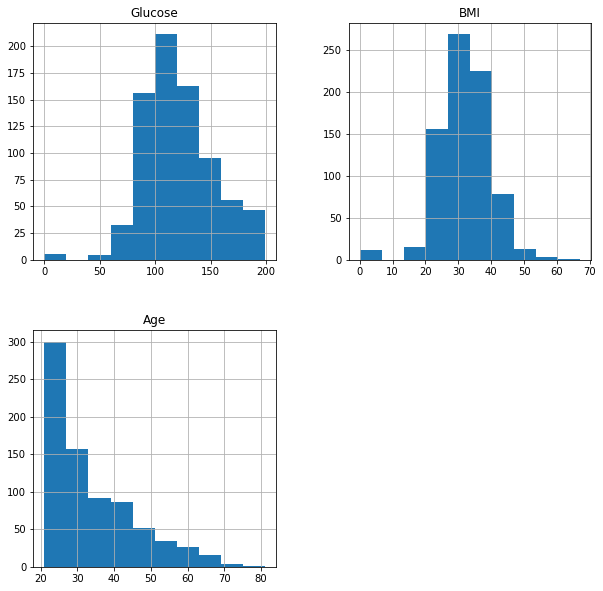

In [15]:
Xi[var].hist(figsize = (10,10))

In [16]:
for v,li,ls in Xi[var].describe(percentiles = [0.01, 0.99]).T[['1%', '99%']].reset_index().values:
    Xi[f'ex_{v}'] = ((Xi[v]<li)|(Xi[v]>ls)).astype(int)
Xi['ex_'] = Xi.filter(like = 'ex_').max(axis = 1)

In [17]:
Xi['ex_'].value_counts(1)

0    0.964844
1    0.035156
Name: ex_, dtype: float64

In [18]:
Xi[vart] = df[vart]

In [19]:
Xi = Xi.loc[Xi['ex_'] == 0].reset_index(drop=True).drop(Xi.filter(like='ex_').columns, axis = 1)

In [1]:
Xi[var].head()

NameError: name 'Xi' is not defined

array([[<AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>]],
      dtype=object)

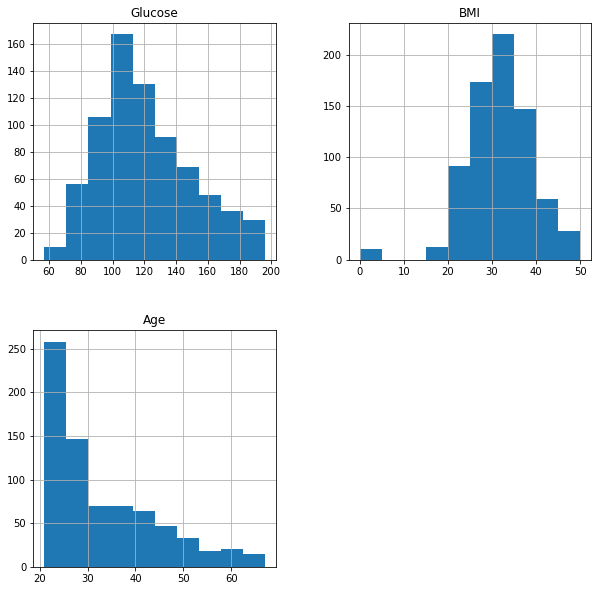

In [21]:
Xi[var].hist(figsize = (10,10))

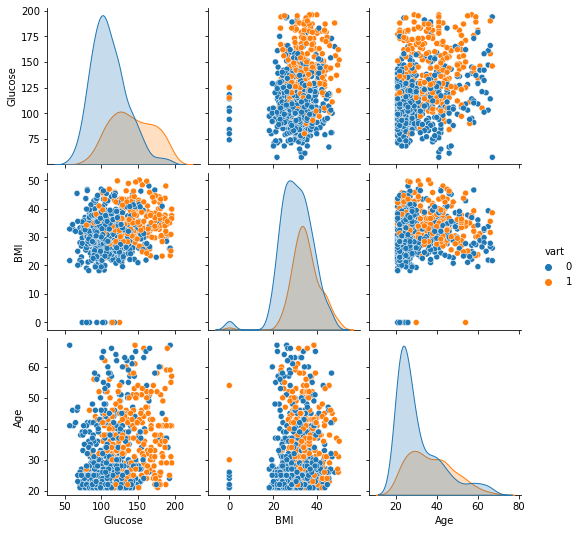

In [22]:
sns.pairplot(data= Xi[var + vart], hue= vart[0])

## Cambio de espacio

In [23]:
sc = MinMaxScaler()
sc.fit(Xi[var])

MinMaxScaler()

In [24]:
X01 = pd.DataFrame(sc.transform(Xi[var]), columns= var)
X01[vart] = Xi[vart]

## Partición

In [25]:
Xt,Xv,yt,yv = train_test_split(X01[var], X01[vart[0]], train_size=0.7)
Xt.reset_index(drop=True, inplace=True)
Xv.reset_index(drop=True, inplace=True)
yt.reset_index(drop=True, inplace=True)
yv.reset_index(drop=True, inplace=True)

## Aprendizaje

### Hiperparametrización 

In [26]:
hp = dict(C = np.arange(0.1,2,0.1),
          kernel = ['linear', 'poly', 'rbf', 'sigmoid'],
          degree = range(2,3),
          probability = [True])

In [27]:
n = reduce(lambda x,y:x*y, [len(y) for x,y in hp.items()])
n

76

In [28]:
modelo = SVC()

In [29]:
grid = RandomizedSearchCV(param_distributions=hp,
                          n_iter= n,
                          cv = 5,
                          scoring= 'accuracy',
                          n_jobs=-1,
                          verbose=True,
                          estimator = modelo)

In [30]:
grid.fit(Xt, yt)

Fitting 5 folds for each of 76 candidates, totalling 380 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=76, n_jobs=-1,
                   param_distributions={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                                        'degree': range(2, 3),
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   scoring='accuracy', verbose=True)

In [31]:
grid.best_params_

{'probability': True, 'kernel': 'poly', 'degree': 2, 'C': 0.2}

In [32]:
modelo = grid.best_estimator_
modelo

SVC(C=0.2, degree=2, kernel='poly', probability=True)

### Búsqueda de parámetros

In [33]:
modelo.fit(Xt, yt)

SVC(C=0.2, degree=2, kernel='poly', probability=True)

## Validación del modelo

In [34]:
print(accuracy_score(y_pred= modelo.predict(Xt), y_true = yt))
print(accuracy_score(y_pred= modelo.predict(Xv), y_true = yv))

0.7876447876447876
0.7533632286995515


In [35]:
print(confusion_matrix(y_pred= modelo.predict(Xt), y_true = yt))
print(confusion_matrix(y_pred= modelo.predict(Xv), y_true = yv))

[[317  31]
 [ 79  91]]
[[123  16]
 [ 39  45]]
